## Predicting Crypto Prices
### Using Machine Learning
Author: **Willie Cooley**


The following notebook was inspired by the medium article [_Predict Tomorrow's Bitcoin (BTC) Price with Recurrent Neural Networks_](https://towardsdatascience.com/using-recurrent-neural-networks-to-predict-bitcoin-btc-prices-c4ff70f9f3e4) by **Orhan Gazi Yalcin**

#### Steps 
  1. Obtaining Historical Crypto Prices
  2. Data Cleaning and Normalization
  3. Building a Recurrent Neural Net with Long Short Term Memory
  4. Training the RNN
  5. Predict tomorrow's price

In [1]:
import pandas as pd
import numpy as np
import requests
import random
import json
import time
import sys

In [2]:
# Coin class for retrieving, cleaning, and normalizing historical data
class Coin():
    valid_timeframes = ['24h', '7d', '30d', '1y', '5y']
    coin_id = { 'BTC': 1 }

    def __init__(self, coin_name='BTC', timeframe='30d', base='USD'):
        '''
            Constructor. sets the URL, Name, data, price matrix, and normalized prices
            of the given coin on creation
        '''
        self.update_coin_ids()
        if self.is_valid_coin(coin_name) and self.is_valid_timeframe(timeframe):
            try:
                self.timeframe = timeframe
                self.base = base
                self.coin_name = coin_name
                self.coin_url = self.generate_coin_url()
                self.data = self.get_historic_prices()
                self.price_matrix = self.get_price_matrix(30)
                self.normalized_prices = self.normalize_prices(self.price_matrix)
            except Exception as e:
                print("Exception Initializing Coin:: " + str(e))
        else:
            print('Invalid Argument(s) Detected.')

    def generate_coin_url(self):
        '''
            Generates a URL for retrieving historical coin data
        '''
        c_url = f'''https://api.coinranking.com/v1/public/coin/{self.coin_id[self.coin_name]}/history/{self.timeframe}?base={self.base}'''
        return c_url

    def get_stats(self):
        '''
            Returns an object with all active information on the coin object.
        '''
        statz = {'coin_name': self.coin_name, 'coin_id': self.coin_id[str(self.coin_name)],
                    'history_timeframe': self.timeframe,
                    'price_matrix': self.get_price_matrix, 'normalized_prices': self.normalized_prices}
        return statz
    
    def get_dataframe(self):
        '''
            Returns a pandas dataframe with available historical data and any requested indicators
        '''
        # TODO: add indicators as columns to dataframe
        return self.data

    def get_historic_prices(self):
        '''
            GETs historic price data for the given coin from the CoinRanking.com API
        '''
        try:
            r = requests.get(self.coin_url)
            coin = json.loads(r.text)['data']['history']
            df = pd.DataFrame(coin)
            df['price'] = pd.to_numeric(df['price'])
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms').dt.date
        except Exception as e:
            print("Exception Getting Historic Prices:: "+str(e))
            return -1
        return df.groupby('timestamp').mean()

    def get_price_matrix(self, seq_len):
        '''
            Converts the price series into a nested list where every item of the list contains
            the historic prices of seq_len number of days
            Function borrowed from: https://gist.github.com/ogyalcin/d893ddb1d49d389ffcfa94cb47e6f5bc#file-rnn_2-py
        '''
        try:
            price_matrix = []
            price_data = self.data['price']
            #print(str(range(len(price_data)-seq_len+1)))
            for index in range(len(price_data)-seq_len+1):
                print(f'adding {self.data[index:index+seq_len]}')
                price_matrix.append(price_data[index:index+seq_len])
            return price_matrix
        except Exception as e:
            print("Exception Getting Price Matrix:: " + str(e))

    def update_coin_ids(self):
        '''
            Function which updates the key/value pairs in self.coin_id to the latest
            information available from the Coinranking.com API
        '''
        c_url = 'https://api.coinranking.com/v1/public/coins'
        try:
            r = requests.get(c_url)
            coinz = json.loads(r.text)['data']['coins']
            for ele in coinz:
                self.coin_id[str(ele['symbol'])] = ele['id']
            return 0
        except Exception as e:
            print("Exception Updating Coin IDs: " + str(e))
            return -1

    def set_timeframe(self, new_tf):
        '''
            Modifies the timeframe parameter of the coin history
        '''
        self.timeframe = new_tf
        reload_data()
        return 0

    def set_base(self, new_base):
        '''
            Modifies the base currency parameter of the coin history
        '''
        self.base = new_base
        reload_data()
        return 0

    def reload_data(self):
        '''
            Updates coin information after parameter changes have been made
        '''
        try:
            self.coin_url = generate_coin_url()
            self.data = self.get_historic_prices()
            self.price_matrix = self.get_price_matrix(30)
            self.normalized_prices = self.normalize_prices(self.price_matrix)
        except Exception as e:
            print("Exception Reloading Data:: "+str(e))
            return -1
        return 0

    def normalize_prices(self, price_data):
        '''
            Normalizes each value to reflect the percentage changes from starting point
            Function borrowed from: https://gist.github.com/ogyalcin/d893ddb1d49d389ffcfa94cb47e6f5bc#file-rnn_2-py
        '''
        normalized_data = []
        try:
            for window in price_data:
                # TODO: check what's actually coming into window[0]
                print(float(window[0]))
                fw0_var = float(window[0]) if float(window[0]) != 0.0 else 1.0
                normalized_window = [((float(p) / fw0_var) - 1) for p in window]
                normalized_data.append(normalized_window)
            return normalized_data
        except Exception as e:
            print("Exception Normalizing Prices:: " +str(e))
            return -1


    # should I move this train_test_split elsewhere in the code?
    ## Options Include: app.py, coin.py, net.py
    def train_test_split_(self, train_size=0.9, shuffle=False, return_row=True):
        '''
            Makes a custom train test split where the last part is kept as the training set.
            Function borrowed from: https://gist.github.com/ogyalcin/d893ddb1d49d389ffcfa94cb47e6f5bc#file-rnn_2-py
        '''
        try:
            self.price_matrix = np.array(self.price_matrix)
            row = int(round(train_size * len(self.price_matrix)))
            train = self.price_matrix[:row, :]
            if shuffle==True:
                np.random.shuffle(train)
            X_train, y_train = train[:row,:-1], train[:row,-1]
            X_test, y_test = self.price_matrix[row:,:-1], self.price_matrix[row:,-1]
            X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
            X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
            if return_row:
                return row, X_train, y_train, X_test, y_test
            else:
                return X_train, y_train, X_test, y_test
        except Exception as e:
            print("Exception Splitting Train and Test Data: " + str(e))
            return -1

    def is_valid_coin(self, coin):
        '''
            Returns True if the provided string is one of the keys in self.coin_id
        '''
        # judging by coinranking's coin list, coins can be 2-5 characters in length
        # all upper-case, Alphabetical. Some coins include an asterisk (*)
        # TODO: regex that checks that input matches the above description
        return True if coin in self.coin_id.keys() else False

    def is_valid_timeframe(self, tf):
        '''
            Returns True if the provided string is present in the list self.valid_timeframes
        '''
        return True if tf in self.valid_timeframes else False

#### Obtaining Historical Bitcoin Prices
To accomplish this, we will make requests to CoinRanking.com's API.

In [3]:
my_eth = Coin('ETH', '1y', 'USD')
eth_prices = my_btc.get_dataframe()

adding                    price
timestamp               
2020-02-02   9314.552805
2020-02-03   9314.312670
2020-02-04   9232.107722
2020-02-05   9417.956071
2020-02-06   9698.087278
2020-02-07   9776.703862
2020-02-08   9803.973497
2020-02-09  10036.537917
2020-02-10  10050.373489
2020-02-11   9937.284647
2020-02-12  10317.919435
2020-02-13  10278.674489
2020-02-14  10254.252397
2020-02-15  10141.692719
2020-02-16   9898.376271
2020-02-17   9709.862783
2020-02-18   9821.867693
2020-02-19  10077.718049
2020-02-20   9589.090470
2020-02-21   9682.612585
2020-02-22   9667.572479
2020-02-23   9848.893182
2020-02-24   9742.213568
2020-02-25   9508.225485
2020-02-26   9054.544661
2020-02-27   8794.222295
2020-02-28   8692.700178
2020-02-29   8682.460279
2020-03-01   8568.460383
2020-03-02   8745.346548
adding                    price
timestamp               
2020-02-03   9314.312670
2020-02-04   9232.107722
2020-02-05   9417.956071
2020-02-06   9698.087278
2020-02-07   9776.703862
2020-02-08 

In [4]:
def plot_data(df):
    #print(df)
    try:
        df.plot(figsize=(21,7), alpha=0.75)
        return 0
    except Exception as e:
        print(str(e))
        return -1

0

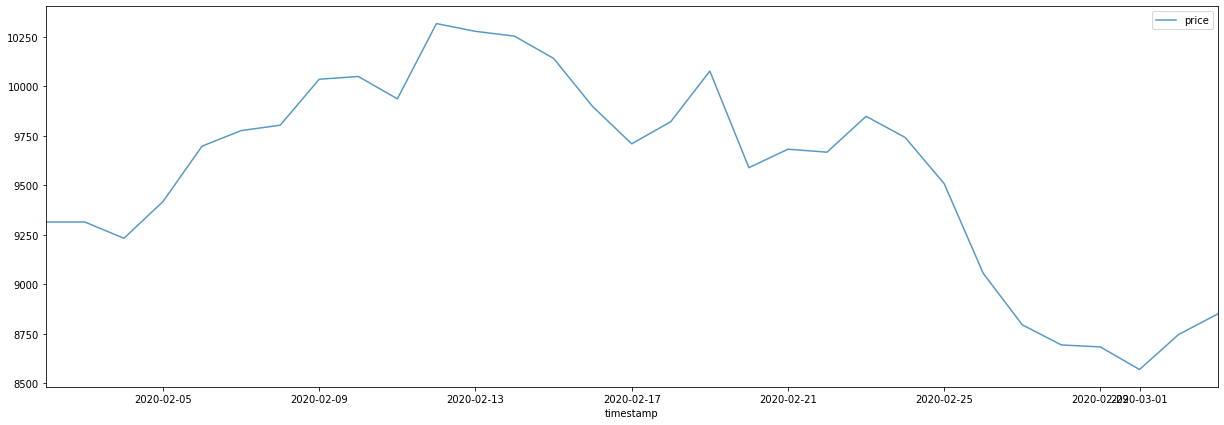

In [6]:
plot_data(eth_prices)

#### Building an RNN with LSTM
Pytorch Translation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
input_shape = (None, 1)
output_dim = 30

In [ ]:
# The below is borrowed from
# https://romanorac.github.io/.../time-series-prediction-with-lstm.html

class Net(nn.Module):
    def __init__(self, input_shape, hidden_size, output_dim):
        super(Net, self).__init__()
        self.input_size = input_shape
        self.hidden_size = hidden_size
        self.output_size = output_dim
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, input, future=0, y=None):
        outputs = []
        
        # reset the state of the LSTM
        # the state is kept until the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        
        for i,input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t,c_t = self.lstm(input_t, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
            
        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            h_t,c_t = self.lstm(output, (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [ ]:
class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=100,
        n_epochs=15,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []

            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)

            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) / 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

In [ ]:
def generate_sequence(scaler, model, x_sample, future=1000):
    """ Generate future values for x_sample with the model """
    y_pred_tensor = model(x_sample, future=future)
    y_pred = y_pred_tensor.cpu().tolist()
    y_pred = scaler.inverse_transform(y_pred)
    return y_pred

In [ ]:
def to_dataframe(actual, predicted):
    return pd.DataFrame({"actual": actual, "predicted": predicted})


def inverse_transform(scalar, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

#### Training the RNN

In [ ]:
model_1 = Model(input_size=1, hidden_size=21, output_size=1)
loss_fn_1 = nn.MSELoss()
optimizer_1 = optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = optim.lr_scheduler.StepLR(optimizer_1, step_size=5, gamma=0.1)
optimization_1 = Optimization(model_1, loss_fn_1, optimizer_1, scheduler_1)

In [ ]:
optimization_1.train(x_train, y_train, x_val, y_val, do_teacher_forcing=False)

In [ ]:
optimization_1.plot_losses()

#### Model Evaluation

In [ ]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_test, y_test, future=5, batch_size=100)
df_result_1 = to_dataframe(actual_1, predicted_1) 
df_result_1 = inverse_transform(scaler, df_result_1, ['actual', 'predicted'])
df_result_1.plot(figsize=(14, 7))
print("Test loss %.4f" % test_loss_1)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))
df_result_1.iloc[2350:2450].plot(ax=axes[0], figsize=(14, 7))
df_result_1.iloc[16000:17500].plot(ax=axes[1], figsize=(14, 7))

In [ ]:
x_sample = x_test[0].reshape(1, -1)
y_sample = df_test.vwap[:1100]
 
y_pred1 = generate_sequence(scaler, optimization_1.model, x_sample)

In [ ]:



















# EOF